<style>
    h1 {
    font-family: 'Segoe UI Semibold';
    font-size: 50px;
    text-align: center;
  }
</style>

# PROYECTO 3: Saber 11

<style>
  .image {
            overflow: hidden;
            width: 100%;
            border-radius: 20px;
            object-fit: cover;
        }
  .container {
            width: 100%;
            height: 300px;
        }

</style>

<div class="container">
    <img src="../img/image.png" class="image"/>
</div>

<style>
  p {
    font-family: 'Segoe UI Light';
    font-size: 20px;
    text-align: center;
  }
</style>

<div style="text-align: center;">
  Analítica Computacional para la Toma de Decisiones IIND-4130 <br>
  Universidad de los Andes &copy; 2024 <br>
  19 de noviembre de 2024 <br><br>
  <strong>GRUPO 7:</strong> <br>
  Laura Calderón - 202122045 <br>
  Camilo Duque - 202024289<br>
  Daniela Espinosa - 202022615<br>
</div>


## **Tarea 2**
Limpieza de Datos

### **Proceso de Limpieza Previo en AWS Athena**

A continuación, se describe el proceso de limpieza y preparación realizado en AWS Athena para la obtención de una tabla depurada que será utilizada en el análisis:

1. **Filtrado por Departamento:**
   - Se seleccionaron únicamente los registros correspondientes a colegios ubicados en el departamento de **Boyacá**, filtrando la tabla según el campo `cole_depto_ubicacion`.

2. **Eliminación de Registros Duplicados:**
   - Se utilizó la cláusula `DISTINCT` para eliminar registros duplicados de la tabla, asegurando que cada fila representara datos únicos.

3. **Manejo de Datos Faltantes:**
   - Se observó que para los datos correspondientes a los periodos entre `20101` y `20141`, no se disponía de registros sobre los puntajes obtenidos por los estudiantes en las pruebas ICFES. Esto representaba un **43% de datos faltantes** en las columnas relacionadas con los puntajes.
   - Dado que estos registros no aportaban valor al análisis, se decidió **eliminarlos**. Por lo tanto, el estudio se enfoca únicamente en datos desde el periodo `20142` en adelante.

4. **Eliminación de Columnas Redundantes o Poco Informativas:**
   - **`cole_cod_depto_ubicacion`:** Representa únicamente el identificador del departamento (15 para Boyacá). Dado que todos los registros pertenecen al mismo departamento, esta columna se eliminó.
   - **`estu_consecutivo`:** Se verificó que este campo, utilizado como identificador único del estudiante, no tuviera valores duplicados. Tras confirmar su unicidad, se eliminó al no ser relevante para el análisis.
   - **`cole_depto_ubicacion`:** Esta columna también se eliminó, ya que toda la tabla corresponde al departamento de Boyacá y, por ende, no añade información adicional.
   - **`cole_cod_mcpio_ubicacion`:** Este campo numérico representaba el municipio del colegio. Sin embargo, su información es redundante con la columna `cole_mcpio_ubicacion`, que contiene el nombre del municipio. Por lo tanto, se eliminó.
   - **`estu_cod_depto_presentacion` y `estu_cod_mcpio_presentacion`:** Ambas columnas contienen códigos numéricos que representan los departamentos y municipios de presentación del estudiante, pero la misma información ya está disponible en `estu_depto_presentacion` y `estu_mcpio_presentacion`. Por esta razón, se eliminaron.
   - **`estu_cod_reside_depto` y `estu_cod_reside_mcpio`:** Similar a los casos anteriores, estas columnas contienen códigos de los departamentos y municipios de residencia, pero la misma información ya está en `estu_depto_reside` y `estu_mcpio_reside`. Se procedió a eliminarlas.
   - **`cole_cod_dane_establecimiento` y `cole_cod_dane_sede`:** Estas columnas contienen identificadores únicos de los colegios y sedes, pero no aportan valor al análisis y, por ende, se eliminaron.

5. **Resultado Final:**
   - El resultado del proceso es una tabla depurada en AWS Athena. Esta tabla se exportó en formato CSV y será utilizada para continuar con el proceso de limpieza y análisis en este notebook.


<style>
  .image {
            overflow: hidden;
            width: 100%;
            border-radius: 20px;
            object-fit: cover;
        }
  .container {
            width: 100%;
            height: 750px;
        }

</style>

<div class="container">
    <img src="../img/Consulta_Final.png" class="image"/>
</div>

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder

dta = pd.read_csv('../data/Datos_Boyaca.csv')

# Mostrar información básica del DataFrame
print(f"Total de registros: {dta.shape[0]}")
print(f"Total de columnas: {dta.shape[1]}")

# Mostrar un resumen de las columnas
print("\nResumen de columnas:")
print(dta.info())

Total de registros: 100049
Total de columnas: 41

Resumen de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100049 entries, 0 to 100048
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   periodo                      100049 non-null  int64  
 1   estu_tipodocumento           100049 non-null  object 
 2   cole_area_ubicacion          100049 non-null  object 
 3   cole_bilingue                91518 non-null   object 
 4   cole_calendario              100049 non-null  object 
 5   cole_caracter                99600 non-null   object 
 6   cole_codigo_icfes            100049 non-null  int64  
 7   cole_genero                  100049 non-null  object 
 8   cole_jornada                 100049 non-null  object 
 9   cole_mcpio_ubicacion         100049 non-null  object 
 10  cole_naturaleza              100049 non-null  object 
 11  cole_nombre_establecimiento  100049 non-null  

In [2]:
# Verificar que no haya filas duplicadas
duplicados = dta.duplicated()

# Contar cuántas filas duplicadas hay
num_duplicados = duplicados.sum()
print(f"Número de filas duplicadas: {num_duplicados}")

Número de filas duplicadas: 0


In [3]:
# Calcular la cantidad de valores faltantes y el porcentaje
faltantes = dta.isnull().sum()
porcentaje_faltantes = (dta.isnull().sum() / len(dta)) * 100

resumen_faltantes = pd.DataFrame({
    'Valores Faltantes': faltantes,
    'Porcentaje (%)': porcentaje_faltantes
})

# Filtrar para mostrar solo las columnas con valores faltantes
resumen_faltantes = resumen_faltantes[resumen_faltantes['Valores Faltantes'] > 0]
resumen_faltantes = resumen_faltantes.sort_values(by='Porcentaje (%)', ascending=False)

print(resumen_faltantes)

                      Valores Faltantes  Porcentaje (%)
cole_bilingue                      8531        8.526822
fami_estratovivienda               2642        2.640706
fami_tieneinternet                 2464        2.462793
fami_educacionmadre                2382        2.380833
fami_educacionpadre                2381        2.379834
fami_personashogar                 1598        1.597217
fami_cuartoshogar                  1541        1.540245
fami_tieneautomovil                1540        1.539246
fami_tienelavadora                 1491        1.490270
fami_tienecomputador               1489        1.488271
cole_caracter                       449        0.448780
estu_genero                         115        0.114944
estu_depto_reside                    62        0.061970
estu_mcpio_reside                    62        0.061970
desemp_ingles                         2        0.001999
punt_ingles                           2        0.001999


In [4]:
# Crear un diccionario para almacenar la proporción máxima y el valor más repetido por columna
columnas_dominantes = {}

for columna in dta.columns:
    valor_mas_comun = dta[columna].value_counts(normalize=True, dropna=False).idxmax()
    proporción_max = dta[columna].value_counts(normalize=True, dropna=False).max()
    columnas_dominantes[columna] = {'Proporción Max (%)': proporción_max * 100, 'Valor Más Común': valor_mas_comun}

resultado = pd.DataFrame.from_dict(columnas_dominantes, orient='index')
columnas_repetitivas = resultado[resultado['Proporción Max (%)'] >= 95]
columnas_repetitivas = columnas_repetitivas.sort_values(by='Proporción Max (%)', ascending=False)

print("Columnas con 95% o más de valores repetidos:")
print(columnas_repetitivas)


Columnas con 95% o más de valores repetidos:
                          Proporción Max (%) Valor Más Común
cole_calendario                   100.000000               A
estu_estudiante                   100.000000      ESTUDIANTE
estu_privado_libertad              99.947026               N
estu_estadoinvestigacion           99.917041        PUBLICAR
estu_nacionalidad                  99.909045        COLOMBIA
estu_pais_reside                   99.909045        COLOMBIA
estu_depto_reside                  99.371308          BOYACA
estu_depto_presentacion            98.460754          BOYACA
cole_genero                        97.716119           MIXTO
cole_sede_principal                97.330308               S


In [5]:
# Identificar columnas con más del 95% de valores repetidos y eliminnarlas
columnas_a_eliminar = columnas_repetitivas.index.tolist()
dta= dta.drop(columns=columnas_a_eliminar)

In [6]:
# Identificar columnas numéricas en el DataFrame
columnas_numericas = dta.select_dtypes(include=['number']).columns
print("Columnas numéricas:")
print(columnas_numericas)

if len(columnas_numericas) == 0:
    print("No hay columnas numéricas en el DataFrame.")
else:
    print(f"Total de columnas numéricas: {len(columnas_numericas)}")

Columnas numéricas:
Index(['periodo', 'cole_codigo_icfes', 'punt_ingles', 'punt_matematicas',
       'punt_sociales_ciudadanas', 'punt_c_naturales', 'punt_lectura_critica',
       'punt_global'],
      dtype='object')
Total de columnas numéricas: 8


In [7]:
# Identificar las columnas categóricas y las columnas numéricas con faltantes
columnas_categoricas = [
    'cole_bilingue', 'fami_estratovivienda', 'fami_tieneinternet', 
    'fami_educacionmadre', 'fami_educacionpadre', 'fami_tieneautomovil',
    'fami_tienelavadora', 'fami_tienecomputador', 'cole_caracter', 
    'estu_genero','fami_personashogar', 'fami_cuartoshogar','desemp_ingles','estu_cod_reside_mcpio','estu_mcpio_reside'
]

columnas_numericas_faltantes = [
    'punt_ingles', 'punt_global'
]

print("\nSe imputaan valores faltante en columnas categóricas con la moda:")
# Imputar valores faltantes en columnas categóricas con la moda
for col in columnas_categoricas:
    if col in dta.columns:
        moda = dta[col].mode()[0]
        dta[col] = dta[col].fillna(moda)
        print(f" '{col}':  {moda}")

print("\nSe imputaan valores faltante en columnas numéricas con la media:")
# Imputar valores faltantes en columnas numéricas con la media
for col in columnas_numericas_faltantes:
    if col in dta.columns:
        media = dta[col].mean()
        dta[col] = dta[col].fillna(media)
        print(f" '{col}': {media}")

# Verificar que no queden valores faltantes
faltantes_restantes = dta.isnull().sum()
print("\nValores faltantes restantes por columna después de la imputación:")
print(faltantes_restantes[faltantes_restantes > 0])


Se imputaan valores faltante en columnas categóricas con la moda:
 'cole_bilingue':  N
 'fami_estratovivienda':  Estrato 2
 'fami_tieneinternet':  No
 'fami_educacionmadre':  Secundaria (Bachillerato) completa
 'fami_educacionpadre':  Primaria incompleta
 'fami_tieneautomovil':  No
 'fami_tienelavadora':  Si
 'fami_tienecomputador':  Si
 'cole_caracter':  TÉCNICO/ACADÉMICO
 'estu_genero':  F
 'fami_personashogar':  3 a 4
 'fami_cuartoshogar':  Tres
 'desemp_ingles':  A-
 'estu_mcpio_reside':  TUNJA

Se imputaan valores faltante en columnas numéricas con la media:
 'punt_ingles': 51.63191300088958
 'punt_global': 264.74132674989255

Valores faltantes restantes por columna después de la imputación:
Series([], dtype: int64)


### **Limpieza Final de acuerdo a las preguntas de negocio y al plan de acción**

#### **1. ¿Cuáles factores sociodemográficos están más relacionados con el mal desempeño de los estudiantes de colegios de Boyacá en la prueba Saber 11?**
**Columnas relevantes:**
- `fami_estratovivienda` (estrato socioeconómico).
- `fami_educacionmadre` y `fami_educacionpadre` (nivel educativo de los padres).
- `fami_tieneinternet`, `fami_tienecomputador`, `fami_tienelavadora`, `fami_tieneautomovil` (accesos familiares).
- `estu_genero` (género).
- `estu_mcpio_reside` (municipio de residencia).
- `fami_personashogar` y `fami_cuartoshogar` (tamaño del hogar).
- **`periodo`** (para analizar si hay tendencias en el tiempo relacionadas con los factores sociodemográficos).

---

#### **2. ¿¿Qué cambios pueden implementar los directivos de las instituciones educativas en Boyacá para aumentar el puntaje global del colegio en la Prueba Saber 11? ?**
**Columnas relevantes:**
- `cole_area_ubicacion` (rural o urbano).
- `cole_bilingue` (si es bilingüe).
- `cole_caracter` (público/privado).
- `cole_naturaleza` (carácter académico o técnico).
- `cole_jornada` (jornada escolar).
- **`periodo`** (para evaluar si el impacto de estas características ha cambiado en diferentes periodos).

---

  
### **Columnas Eliminadas y Justificación**

1. **Columnas relacionadas con identificadores o información redundante:**
   - `estu_tipodocumento`, `cole_codigo_icfes`, `cole_nombre_establecimiento`, `cole_nombre_sede`, `cole_sede_principal`:
     - Estas columnas contienen información de identificación o etiquetas de colegios y estudiantes que no aportan al análisis del desempeño ni a las preguntas planteadas.

2. **Columnas relacionadas con localización no utilizadas:**
   - `cole_mcpio_ubicacion`, `estu_mcpio_presentacion`:
     - Si bien podrían ser útiles en otros contextos, estas columnas no se alinean directamente con las preguntas seleccionadas. Se priorizó `estu_mcpio_reside` como la variable clave para analizar la ubicación de residencia.

3. **Puntajes específicos de áreas (redundantes)::**
   - `punt_ingles`, `punt_matematicas`,`punt_ingles`, `punt_sociales_ciudadanas`,`punt_c_naturales`,`punt_lectura_critica`:
     - Estos ya están reflejados en punt_global, que es la suma ponderada de estas áreas. Dado que el puntaje global es la variable objetivo, los puntajes específicos se pueden omitir.
  


In [8]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    'estu_tipodocumento',
    'cole_codigo_icfes', 'cole_nombre_establecimiento', 'cole_nombre_sede','estu_fechanacimiento',
    'cole_sede_principal', 'cole_mcpio_ubicacion', 'estu_mcpio_presentacion','punt_ingles', 'desemp_ingles','punt_matematicas','punt_ingles', 'punt_sociales_ciudadanas','punt_c_naturales','punt_lectura_critica'
]

# Eliminar las columnas seleccionadas
dta = dta.drop(columns=columnas_a_eliminar, errors='ignore')


In [9]:
# Mostrar información básica del DataFrame
print(f"Total de registros: {dta.shape[0]}")
print(f"Total de columnas: {dta.shape[1]}")

print(dta.info())

Total de registros: 100049
Total de columnas: 18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100049 entries, 0 to 100048
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   periodo               100049 non-null  int64 
 1   cole_area_ubicacion   100049 non-null  object
 2   cole_bilingue         100049 non-null  object
 3   cole_caracter         100049 non-null  object
 4   cole_jornada          100049 non-null  object
 5   cole_naturaleza       100049 non-null  object
 6   estu_genero           100049 non-null  object
 7   estu_mcpio_reside     100049 non-null  object
 8   fami_cuartoshogar     100049 non-null  object
 9   fami_educacionmadre   100049 non-null  object
 10  fami_educacionpadre   100049 non-null  object
 11  fami_estratovivienda  100049 non-null  object
 12  fami_personashogar    100049 non-null  object
 13  fami_tieneautomovil   100049 non-null  object
 14  fami_tienecomputado

In [10]:
columnas_numericas = dta.select_dtypes(include=['number']).columns
# Mostrar los valores mínimos y máximos para las columnas numéricas
for col in columnas_numericas:
    if col in dta.columns:
        print(f"Columna '{col}': Min = {dta[col].min()}, Max = {dta[col].max()}")

Columna 'periodo': Min = 20142, Max = 20224
Columna 'punt_global': Min = 0, Max = 471


In [11]:
# Seleccionar columnas no numéricas
columnas_no_numericas = dta.select_dtypes(include=['object']).columns

label_encoders = {}
mapeos = {}

for col in columnas_no_numericas:
    le = LabelEncoder()
    dta[col] = le.fit_transform(dta[col].astype(str))
    label_encoders[col] = le
    mapeos[col] = dict(zip(le.classes_, le.transform(le.classes_)))


for col, mapeo in mapeos.items():
    print(f"Columna: {col}")
    for original, transformado in mapeo.items():
        print(f"  {original} -> {transformado}")
    print("-" * 30)

Columna: cole_area_ubicacion
  RURAL -> 0
  URBANO -> 1
------------------------------
Columna: cole_bilingue
  N -> 0
  S -> 1
------------------------------
Columna: cole_caracter
  ACADÉMICO -> 0
  NO APLICA -> 1
  TÉCNICO -> 2
  TÉCNICO/ACADÉMICO -> 3
------------------------------
Columna: cole_jornada
  COMPLETA -> 0
  MAÑANA -> 1
  NOCHE -> 2
  SABATINA -> 3
  TARDE -> 4
  UNICA -> 5
------------------------------
Columna: cole_naturaleza
  NO OFICIAL -> 0
  OFICIAL -> 1
------------------------------
Columna: estu_genero
  F -> 0
  M -> 1
------------------------------
Columna: estu_mcpio_reside
  ACACÍAS -> 0
  AGUACHICA -> 1
  ALBANIA -> 2
  ALMEIDA -> 3
  AQUITANIA -> 4
  ARCABUCO -> 5
  ARMENIA -> 6
  BARBOSA -> 7
  BARRANCABERMEJA -> 8
  BARRANQUILLA -> 9
  BELLO -> 10
  BELÉN -> 11
  BERBEO -> 12
  BETÉITIVA -> 13
  BOAVITA -> 14
  BOGOTÁ D.C. -> 15
  BOYACÁ -> 16
  BRICEÑO -> 17
  BUCARAMANGA -> 18
  BUENAVISTA -> 19
  BUSBANZÁ -> 20
  CAJICÁ -> 21
  CALDAS -> 22
  CALI 

In [12]:
for col in columnas_no_numericas:
    print(f"Frecuencia de valores en '{col}':")
    print(dta[col].value_counts())
    print("-" * 30)

Frecuencia de valores en 'cole_area_ubicacion':
cole_area_ubicacion
1    84547
0    15502
Name: count, dtype: int64
------------------------------
Frecuencia de valores en 'cole_bilingue':
cole_bilingue
0    98927
1     1122
Name: count, dtype: int64
------------------------------
Frecuencia de valores en 'cole_caracter':
cole_caracter
3    45951
0    32206
2    21246
1      646
Name: count, dtype: int64
------------------------------
Frecuencia de valores en 'cole_jornada':
cole_jornada
0    48411
1    34599
5     6354
4     4745
3     4171
2     1769
Name: count, dtype: int64
------------------------------
Frecuencia de valores en 'cole_naturaleza':
cole_naturaleza
1    81513
0    18536
Name: count, dtype: int64
------------------------------
Frecuencia de valores en 'estu_genero':
estu_genero
0    53338
1    46711
Name: count, dtype: int64
------------------------------
Frecuencia de valores en 'estu_mcpio_reside':
estu_mcpio_reside
185    15672
50     11684
157    11214
29      627

In [13]:
dta

,periodo,cole_area_ubicacion,cole_bilingue,cole_caracter,cole_jornada,cole_naturaleza,estu_genero,estu_mcpio_reside,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,punt_global
0,20224,1,0,2,5,1,1,185,3,10,9,0,1,0,0,0,0,270
1,20224,0,0,0,0,1,0,140,9,0,7,1,1,1,0,0,1,186
2,20224,0,0,3,0,1,0,179,9,8,7,2,1,0,1,1,1,215
3,20224,0,0,2,5,1,1,106,1,9,6,2,2,0,1,1,0,273
4,20224,1,0,3,5,1,1,185,9,8,8,1,1,1,1,1,1,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100044,20172,1,0,2,1,1,0,185,9,9,9,2,1,1,1,1,1,222
100045,20152,1,0,0,1,1,1,106,9,0,0,1,15,1,1,1,1,325
100046,20142,0,0,2,0,1,0,57,1,6,7,0,11,0,0,0,0,232
100047,20152,1,0,3,1,1,0,185,3,9,6,1,5,0,0,0,0,227


## **Tarea 3**
Exploración de Datos

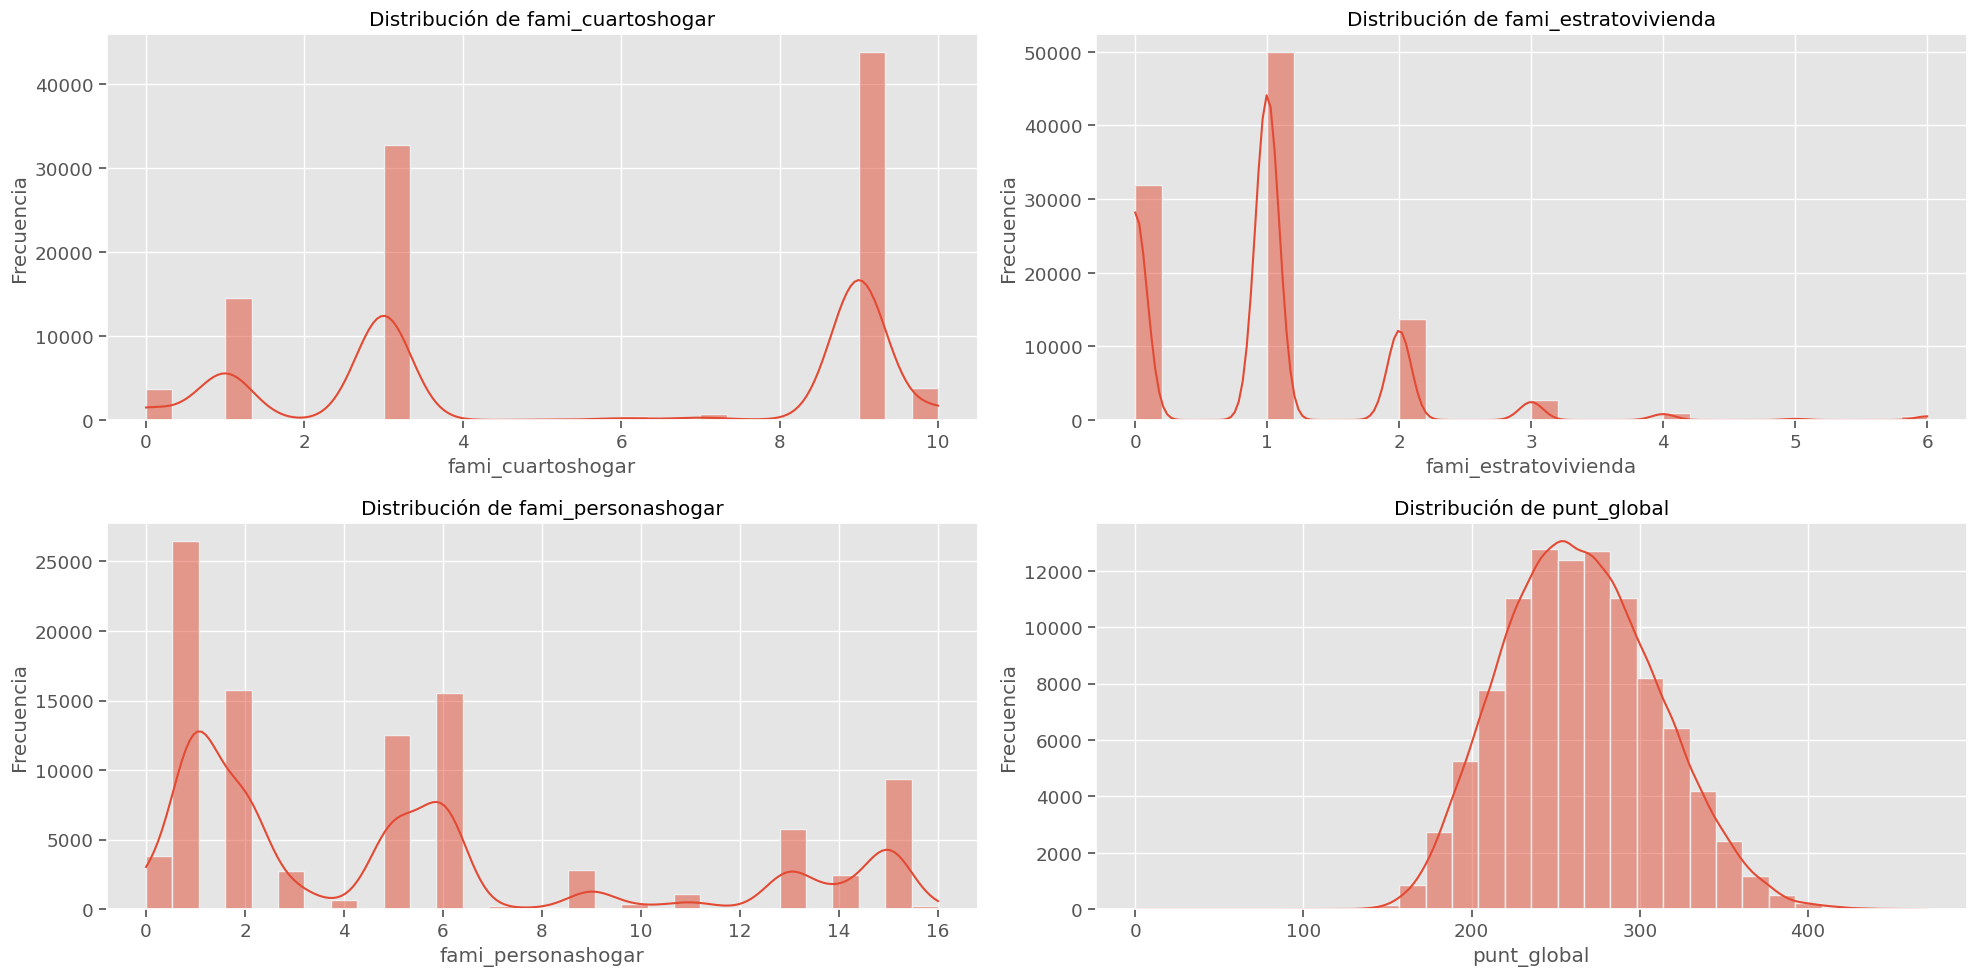

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

data = dta.copy()

# Configuración de estilos para matplotlib y seaborn
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Definición de columnas
columnas_numericas = [
    'fami_cuartoshogar', 'fami_estratovivienda', 'fami_personashogar', 
    'punt_global'
]
columnas_categoricas = [
    'cole_area_ubicacion', 'cole_bilingue', 'cole_caracter', 'cole_jornada', 
    'cole_naturaleza', 'estu_genero', 'fami_tieneautomovil', 
    'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora'
]

# 1. Histogramas para columnas numéricas
plt.figure(figsize=(20, 10))

for i, col in enumerate(columnas_numericas[:4]):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


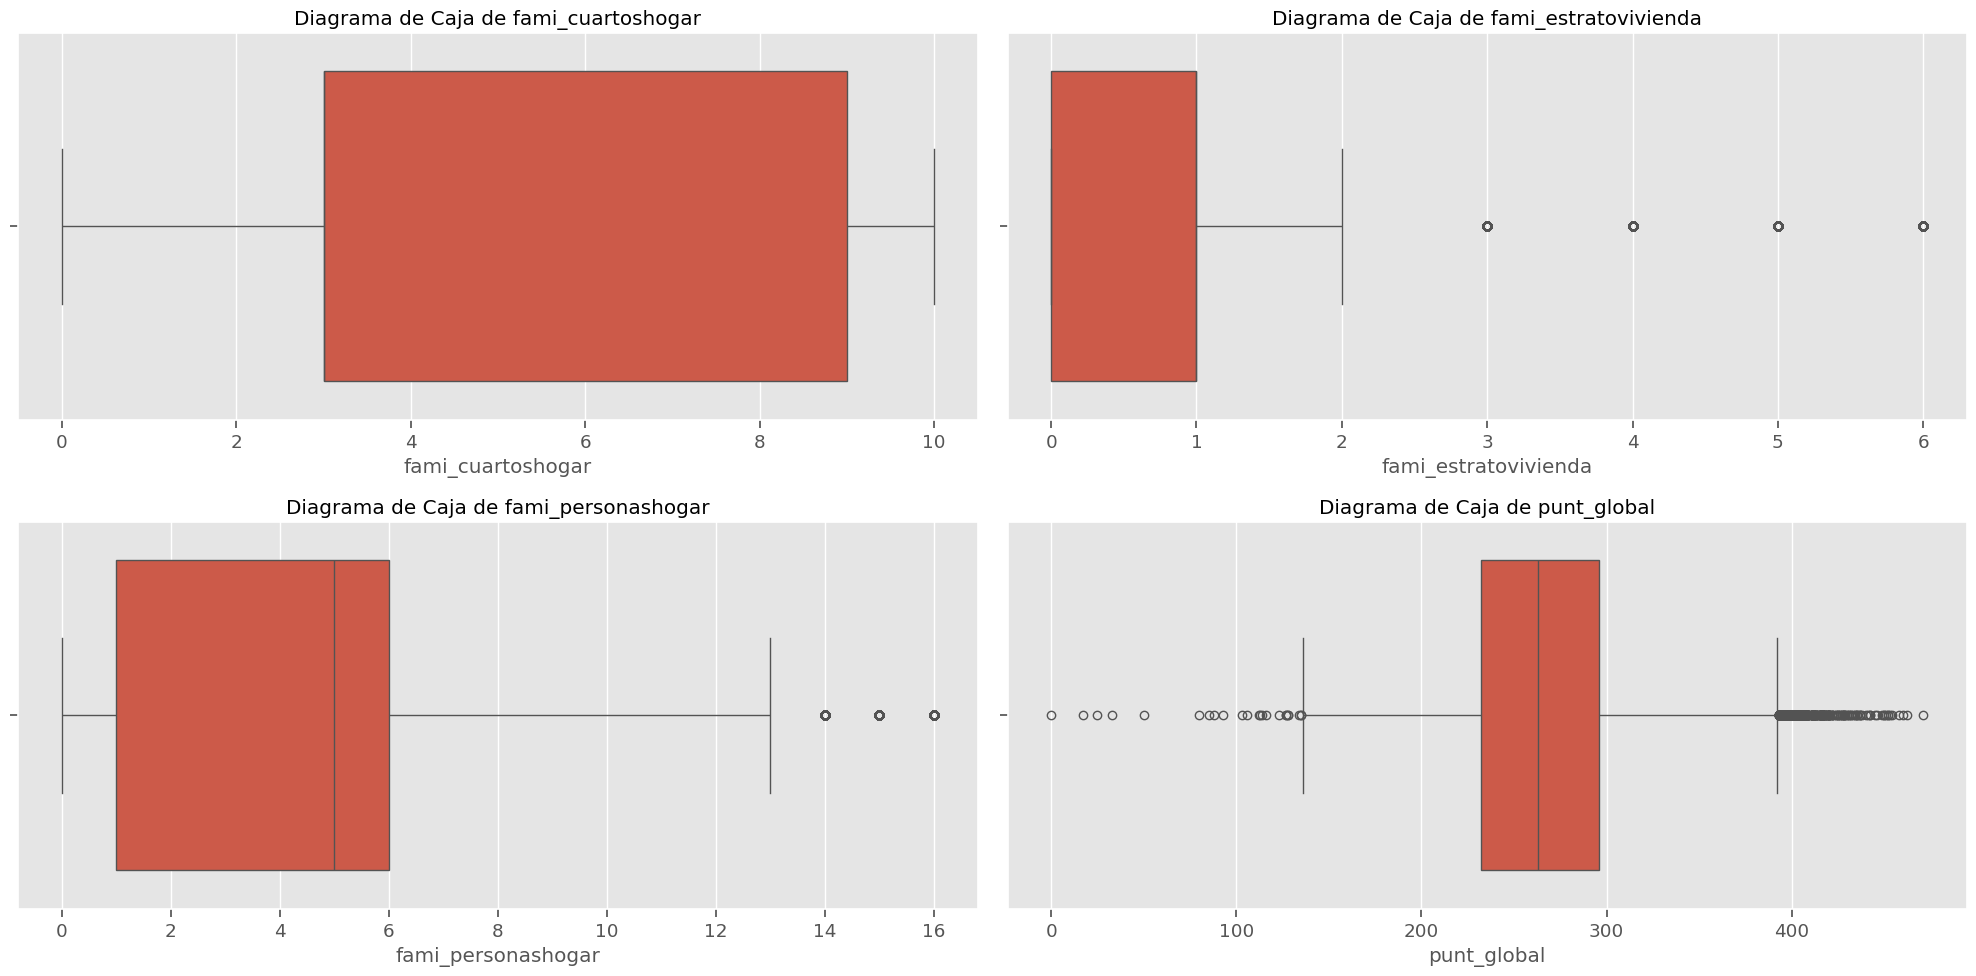

In [15]:
# 2. Diagramas de caja para valores atípicos
plt.figure(figsize=(20, 10))

for i, col in enumerate(columnas_numericas):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=data[col])
    plt.title(f'Diagrama de Caja de {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

todas_las_columnas = columnas_numericas + columnas_categoricas

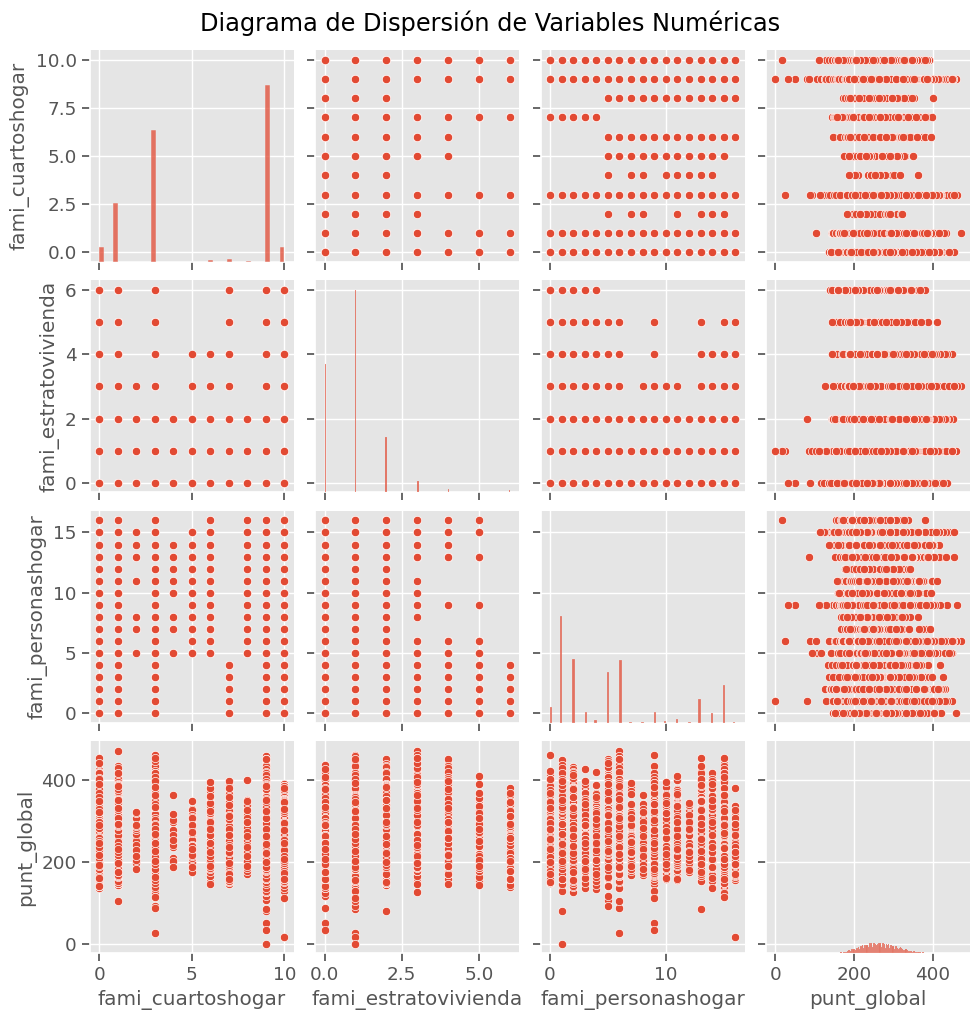

: 

In [ ]:
# 3. Pairplot para analizar relaciones entre variables numéricas
sns.pairplot(data[columnas_numericas])
plt.suptitle("Diagrama de Dispersión de Variables Numéricas", y=1.02)
plt.show()

In [ ]:
# 4. Gráficos de barras para variables categóricas
plt.figure(figsize=(20, 10))

for i, col in enumerate(columnas_categoricas):
    plt.subplot(2, 5, i + 1)
    sns.countplot(data=data, x=col)
    plt.title(f'Frecuencia de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

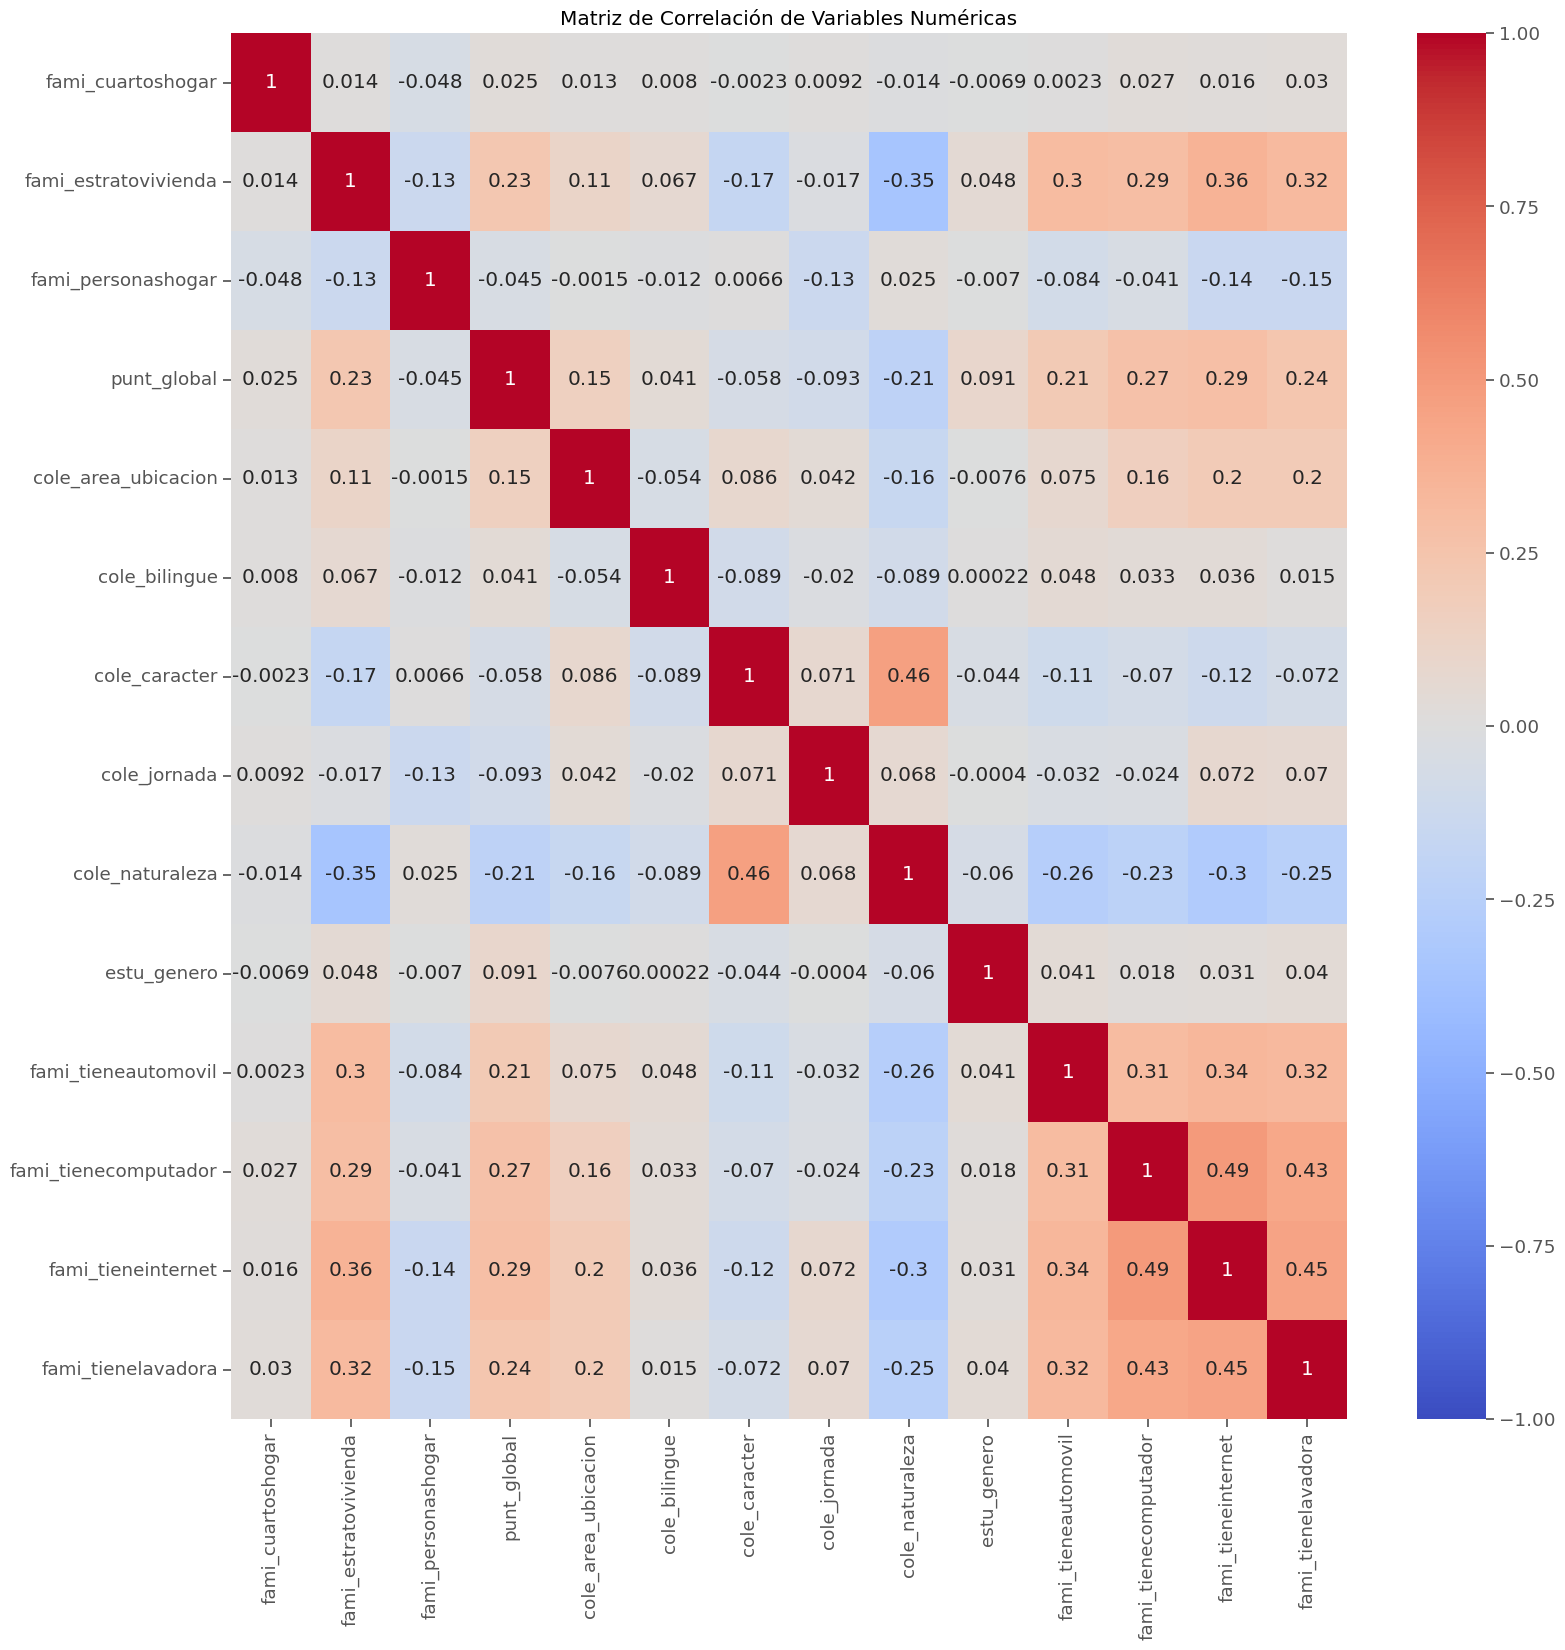

In [ ]:
# 5. Mapa de calor de correlación
todas_las_columnas = columnas_numericas + columnas_categoricas

plt.figure(figsize=(18, 18))
matriz_correlacion = data[todas_las_columnas].corr()
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

## **Tarea 4**
Modelamiento


In [14]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


# Lista de columnas a eliminar
#columnas_corr_negativa = [
#    'cole_caracter','cole_jornada', 'cole_naturaleza'
#]

# Eliminar las columnas seleccionadas
#dta = dta.drop(columns=columnas_corr_negativa, errors='ignore')

# Periodo es la única columna a normalizar
columnas_a_normalizar = [
     'periodo'
]

scaler = MinMaxScaler()
dta[columnas_a_normalizar] = scaler.fit_transform(dta[columnas_a_normalizar])



#### **Primer Modelo: Red neuronal básica (Regresión)**
Características:
- Dos capas ocultas.
- Sin regularización.

#### **Segundo Modelo:Red con más capas (Regresión Profunda)**
Características:
- Cuatro capas ocultas.
- Más neuronas por capa.
- Sin regularización.

#### **Tercer Modelo:Red con Dropout**
Características:
- Dos capas ocultas.
- Incluye Dropout para prevenir sobreajuste.

#### **Cuarto Modelo: Red con Regularización L2**
Características:
- Dos capas ocultas.
- Regularización L2 para penalizar pesos grandes.

Evaluando Básico con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


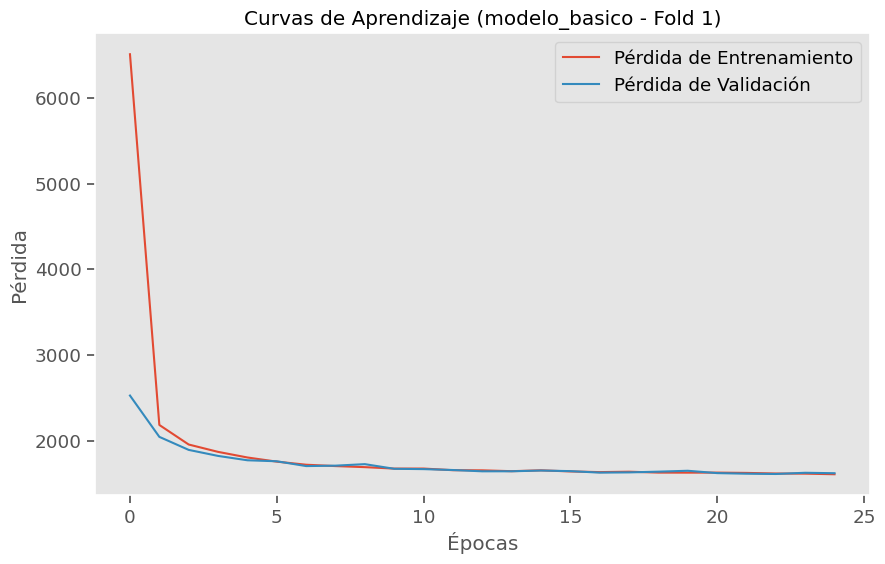

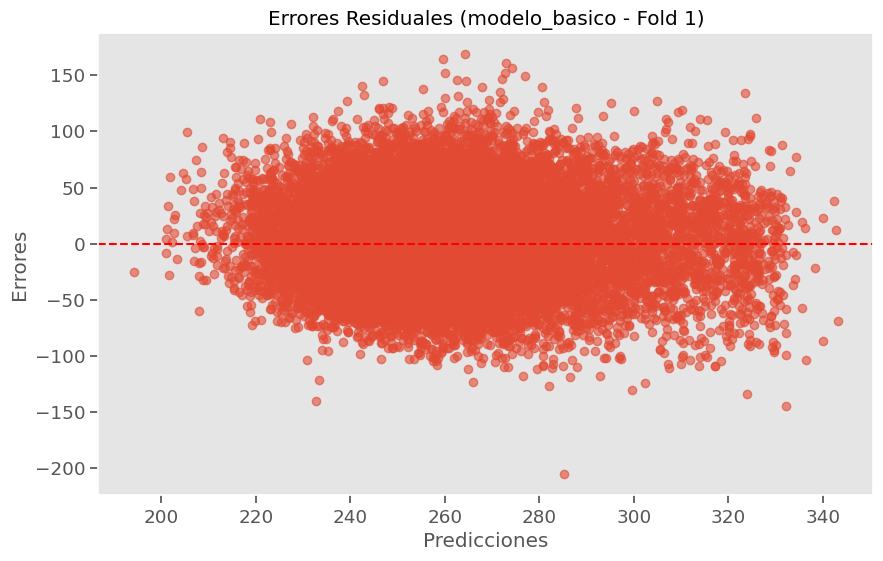

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluando Profundo con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


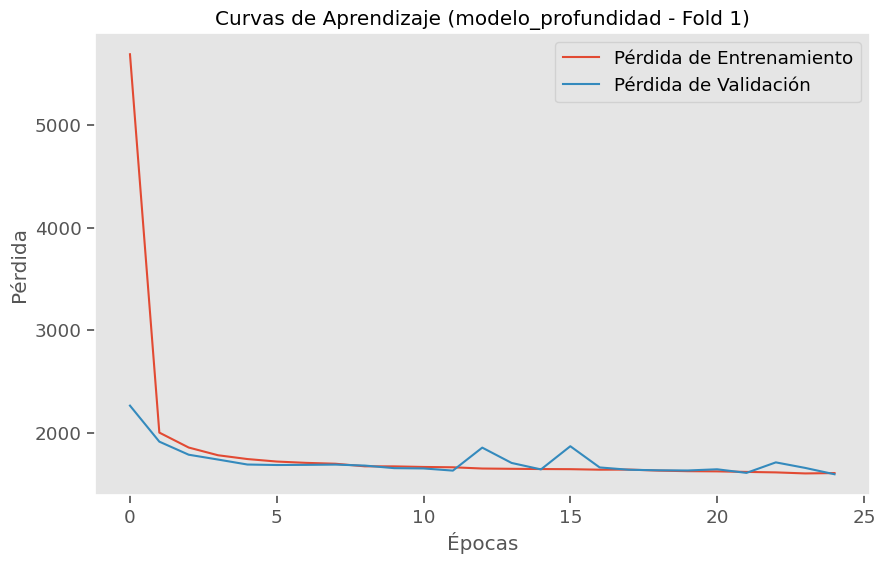

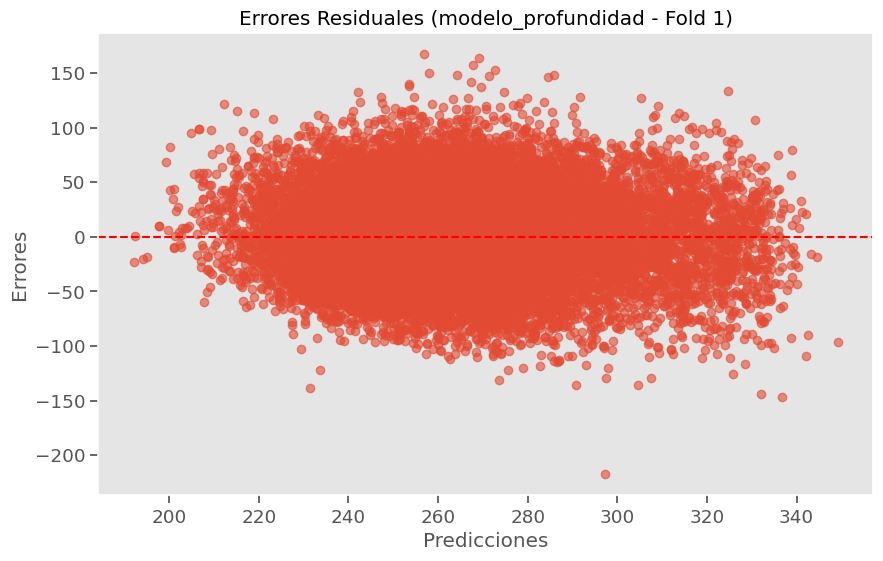

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Evaluando Dropout con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


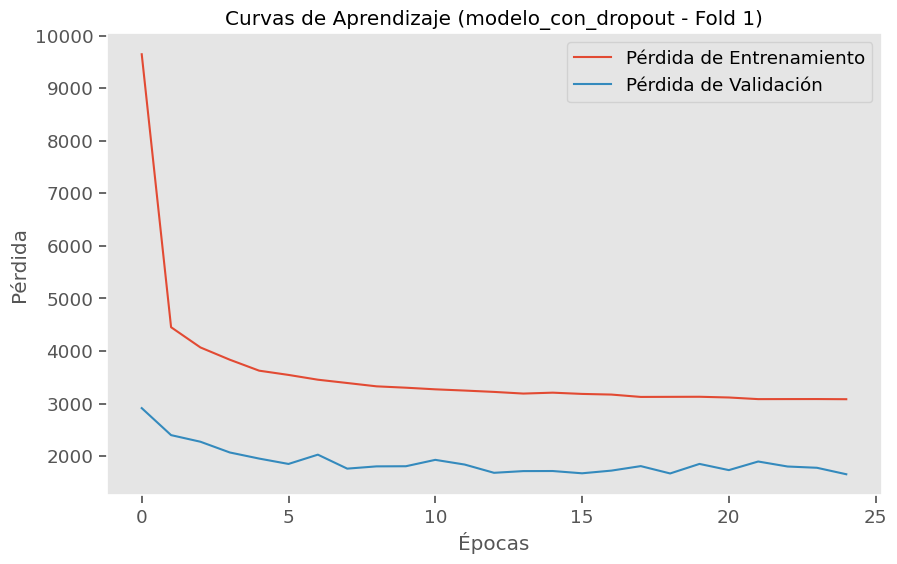

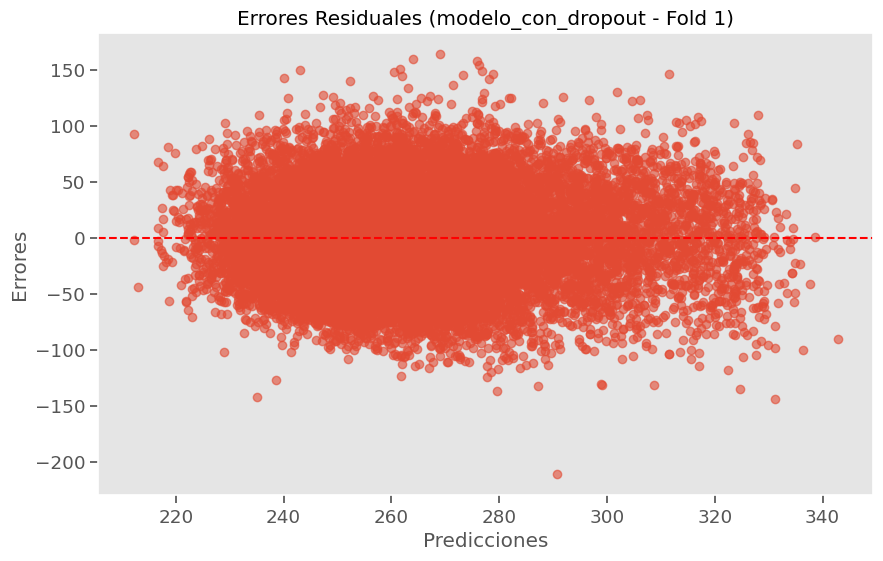

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluando L2 Regularización con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


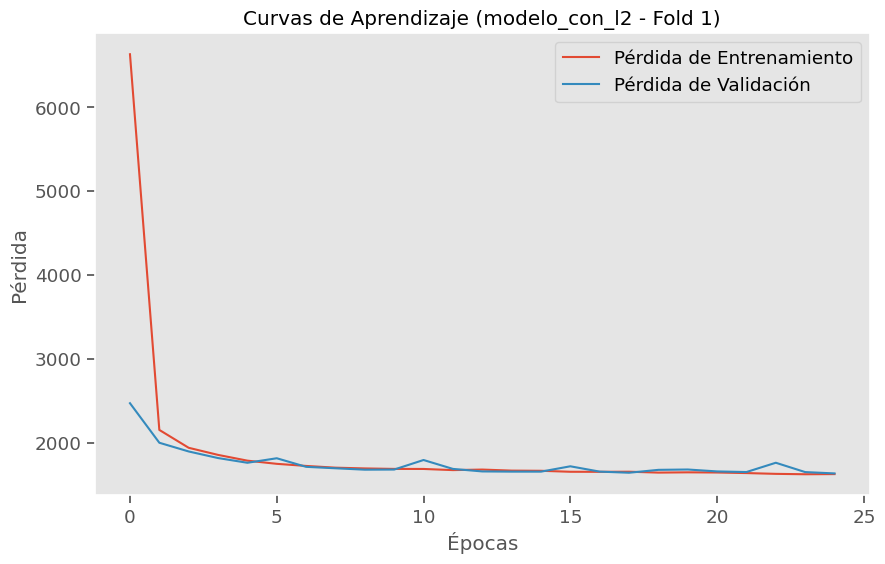

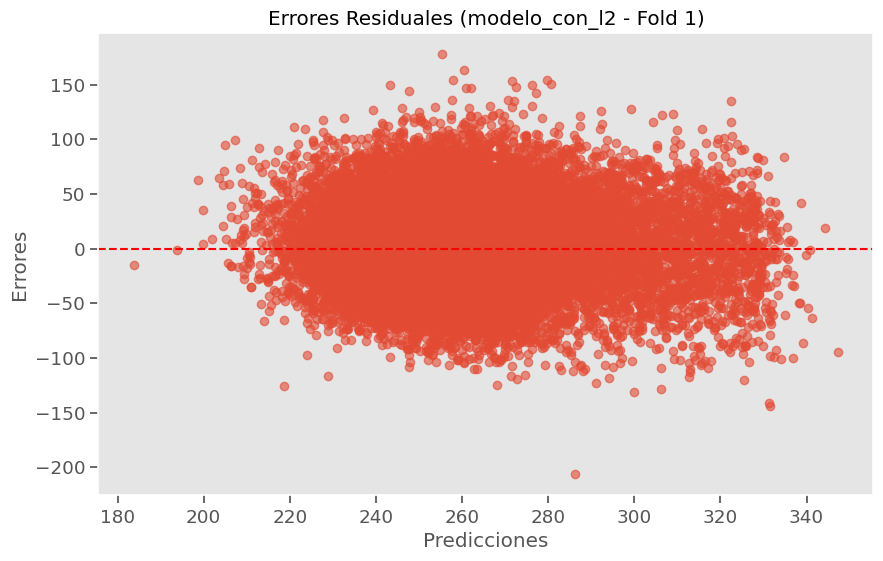

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Resultados Promedio (K-Fold):
Básico: MSE=1607.4853, R2=0.2299, MAE=32.2372
Profundo: MSE=1589.5621, R2=0.2385, MAE=32.0797
Dropout: MSE=1703.8120, R2=0.1837, MAE=33.1861
L2 Regularización: MSE=1650.2183, R2=0.2092, MAE=32.6690


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Funciones de Modelos
def modelo_basico(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Predicción de puntaje global
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_profundidad(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)  # Predicción de puntaje global
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_con_dropout(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.2), 
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Predicción de puntaje global
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_con_l2(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1)  # Predicción de puntaje global
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Función para Graficar Curvas de Aprendizaje
def plot_learning_curve(history, modelo):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Curvas de Aprendizaje ({modelo})')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid()
    plt.show()

# Función para Graficar Errores Residuales
def plot_residuals(y_true, y_pred, modelo):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Errores Residuales ({modelo})')
    plt.xlabel('Predicciones')
    plt.ylabel('Errores')
    plt.grid()
    plt.show()

# Evaluación con K-Fold
def evaluar_kfold(model_fn, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)   
    fold_metrics = {'mse': [], 'r2': [], 'mae': []}
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Construir modelo
        model = model_fn(X_train.shape[1])
        history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2, verbose=0) # CUANTAS EPOOCASSSSS???????????????? Y batch_sice 32 o 64?
        
        # Predicciones
        y_pred = model.predict(X_test).flatten()
        
        # Métricas
        fold_metrics['mse'].append(mean_squared_error(y_test, y_pred))
        fold_metrics['r2'].append(r2_score(y_test, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        
        # Gráficas por cada fold (opcional)
        if fold == 0:  # Solo graficar el primer fold
            plot_learning_curve(history, f'{model_fn.__name__} - Fold {fold+1}')
            plot_residuals(y_test, y_pred, f'{model_fn.__name__} - Fold {fold+1}')
    
    # Promediar métricas
    for key in fold_metrics:
        fold_metrics[key] = np.mean(fold_metrics[key])
    
    return fold_metrics

# Preparar datos para K-Fold
X = dta.drop(columns=['punt_global']).values
y = dta['punt_global'].values

# Evaluar los Modelos
modelos = {
    "Básico": modelo_basico,
    "Profundo": modelo_profundidad,
    "Dropout": modelo_con_dropout,
    "L2 Regularización": modelo_con_l2,
}

resultados_kfold = {}

for nombre, modelo_fn in modelos.items():
    print(f"Evaluando {nombre} con K-Fold...")
    metrics = evaluar_kfold(modelo_fn, X, y)
    resultados_kfold[nombre] = metrics

# Mostrar Resultados Promedio
print("\nResultados Promedio (K-Fold):")
for nombre, metrics in resultados_kfold.items():
    print(f"{nombre}: MSE={metrics['mse']:.4f}, R2={metrics['r2']:.4f}, MAE={metrics['mae']:.4f}")


Evaluando Básico con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


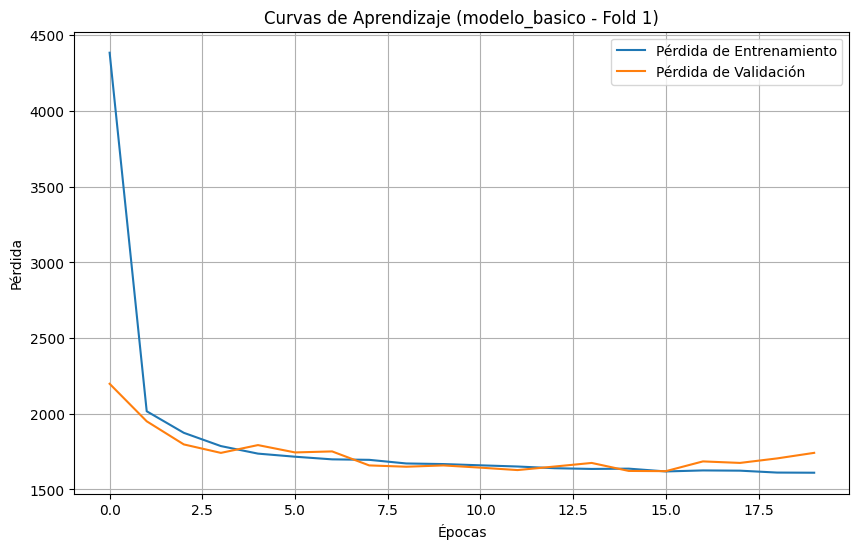

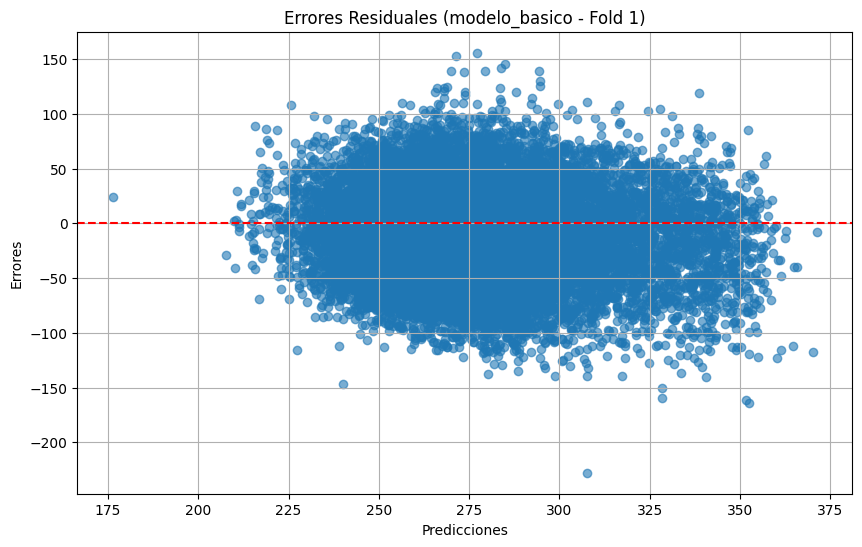

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Evaluando Profundo con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


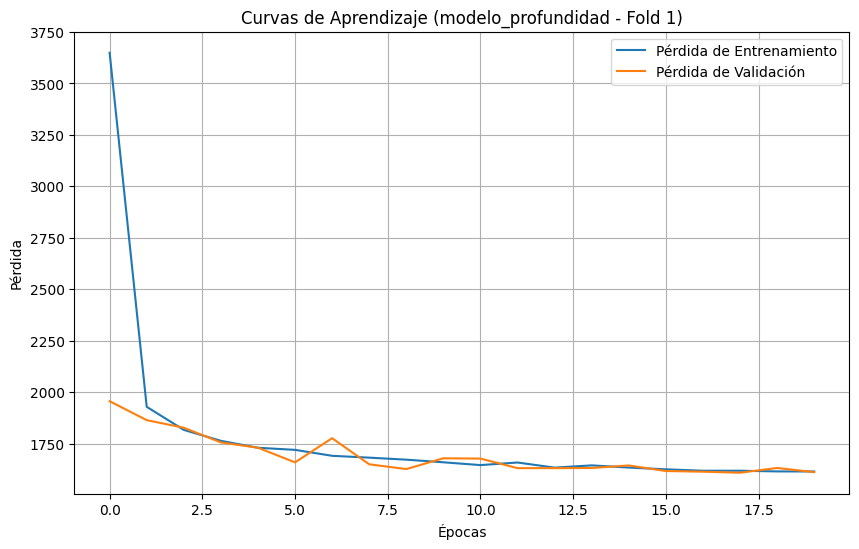

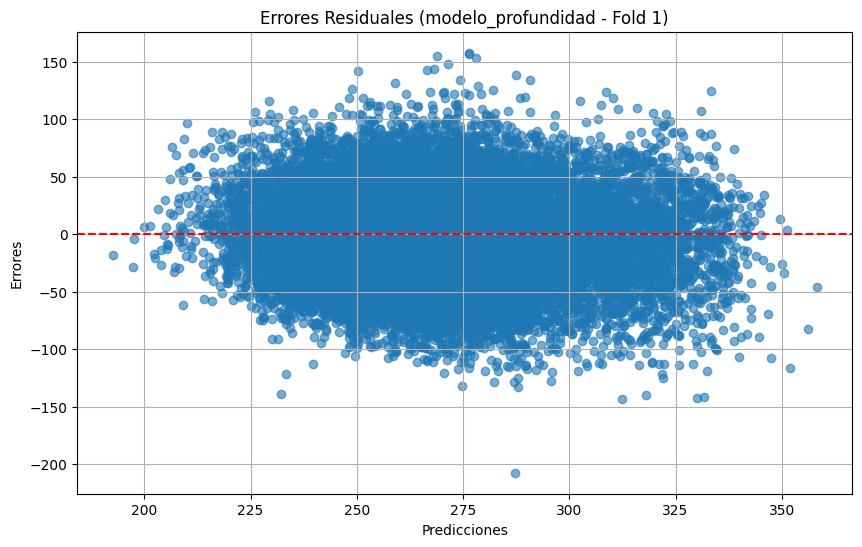

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Evaluando Dropout con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


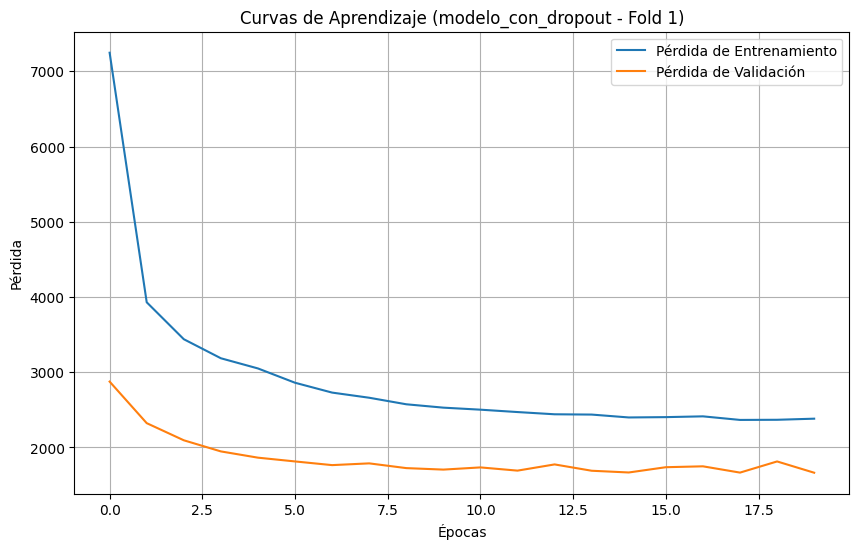

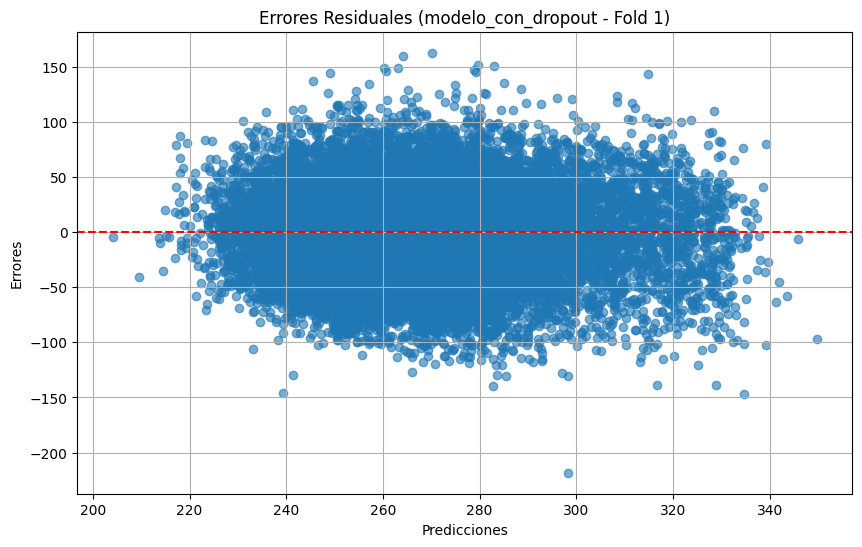

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Evaluando L2 Regularización con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


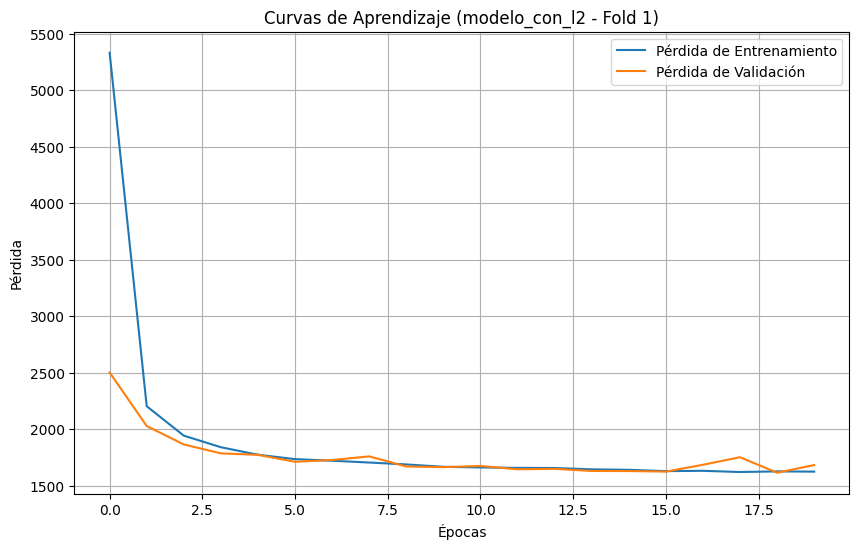

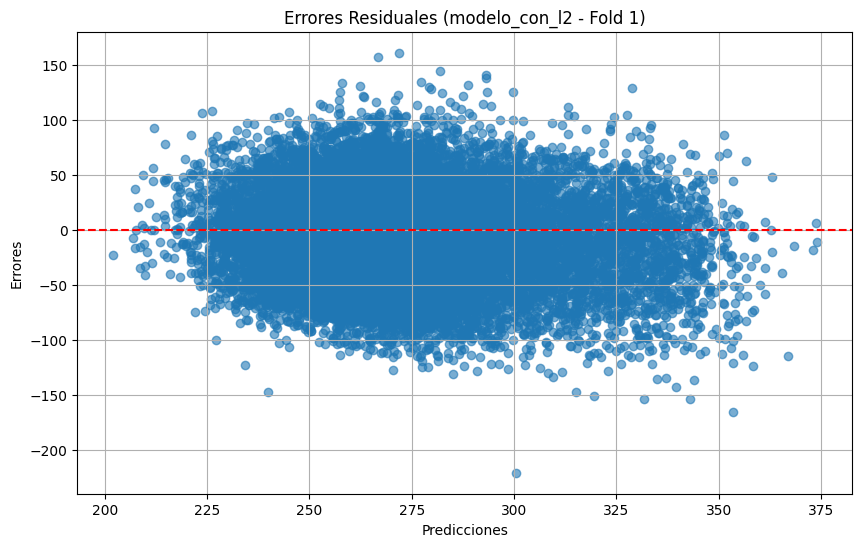

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Resultados Promedio (K-Fold):
Básico: MSE=1627.0141, R2=0.2204, MAE=32.4444
Profundo: MSE=1588.9395, R2=0.2387, MAE=32.0632
Dropout: MSE=1672.2029, R2=0.1989, MAE=32.8890
L2 Regularización: MSE=1669.3158, R2=0.2001, MAE=32.7942


In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

# Funciones de Modelos con ajustes
def modelo_basico(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),  # Incremento de neuronas
        Dense(64, activation='relu'),
        Dense(1)  # Predicción de puntaje global
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_profundidad(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu'),  # Aumentar capas y neuronas
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_con_dropout(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation=LeakyReLU(alpha=0.01)),  # Usar Leaky ReLU
        Dropout(0.3),  # Aumentar dropout para evitar sobreajuste
        Dense(64, activation=LeakyReLU(alpha=0.01)),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_con_l2(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.01)),
        Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Función para Graficar Curvas de Aprendizaje
def plot_learning_curve(history, modelo):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title(f'Curvas de Aprendizaje ({modelo})')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid()
    plt.show()

# Función para Graficar Errores Residuales
def plot_residuals(y_true, y_pred, modelo):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Errores Residuales ({modelo})')
    plt.xlabel('Predicciones')
    plt.ylabel('Errores')
    plt.grid()
    plt.show()

# Evaluación con K-Fold
def evaluar_kfold(model_fn, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = {'mse': [], 'r2': [], 'mae': []}
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Construir modelo
        model = model_fn(X_train.shape[1])
        history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0) 
        
        # Predicciones
        y_pred = model.predict(X_test).flatten()
        
        # Métricas
        fold_metrics['mse'].append(mean_squared_error(y_test, y_pred))
        fold_metrics['r2'].append(r2_score(y_test, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_test, y_pred))
        
        # Gráficas por cada fold (opcional)
        if fold == 0:  # Solo graficar el primer fold
            plot_learning_curve(history, f'{model_fn.__name__} - Fold {fold+1}')
            plot_residuals(y_test, y_pred, f'{model_fn.__name__} - Fold {fold+1}')
    
    # Promediar métricas
    for key in fold_metrics:
        fold_metrics[key] = np.mean(fold_metrics[key])
    
    return fold_metrics

# Preparar datos para K-Fold
X = dta.drop(columns=['punt_global']).values
y = dta['punt_global'].values

# Evaluar los Modelos
modelos = {
    "Básico": modelo_basico,
    "Profundo": modelo_profundidad,
    "Dropout": modelo_con_dropout,
    "L2 Regularización": modelo_con_l2,
}

resultados_kfold = {}

for nombre, modelo_fn in modelos.items():
    print(f"Evaluando {nombre} con K-Fold...")
    metrics = evaluar_kfold(modelo_fn, X, y)
    resultados_kfold[nombre] = metrics

# Mostrar Resultados Promedio
print("\nResultados Promedio (K-Fold):")
for nombre, metrics in resultados_kfold.items():
    print(f"{nombre}: MSE={metrics['mse']:.4f}, R2={metrics['r2']:.4f}, MAE={metrics['mae']:.4f}")


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU

# Funciones de Modelos con Leaky ReLU y activación Sigmoid
def modelo_basico(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.01),
        Dense(64, activation='sigmoid'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_profundidad(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),
        LeakyReLU(alpha=0.01),
        Dense(128, activation='sigmoid'),
        Dense(64, activation='sigmoid'),
        Dense(32, activation='sigmoid'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_con_dropout(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.01),
        Dropout(0.3),
        Dense(64, activation='sigmoid'),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def modelo_con_l2(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, kernel_regularizer=l2(0.01)),
        LeakyReLU(alpha=0.01),
        Dense(64, activation='sigmoid', kernel_regularizer=l2(0.01)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Evaluación con K-Fold
def evaluar_kfold(model_fn, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = {'mse': [], 'r2': [], 'mae': []}
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = model_fn(X_train.shape[1])
        history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=0)
        
        y_pred = model.predict(X_test).flatten()
        
        fold_metrics['mse'].append(mean_squared_error(y_test, y_pred))
        fold_metrics['r2'].append(r2_score(y_test, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_test, y_pred))
    
    for key in fold_metrics:
        fold_metrics[key] = np.mean(fold_metrics[key])
    
    return fold_metrics

# Preparar datos
X = dta.drop(columns=['punt_global']).values
y = dta['punt_global'].values

# Evaluar los Modelos
modelos = {
    "Básico": modelo_basico,
    "Profundo": modelo_profundidad,
    "Dropout": modelo_con_dropout,
    "L2 Regularización": modelo_con_l2,
}

resultados_kfold = {}

for nombre, modelo_fn in modelos.items():
    print(f"Evaluando {nombre} con K-Fold...")
    metrics = evaluar_kfold(modelo_fn, X, y)
    resultados_kfold[nombre] = metrics

# Mostrar Resultados Promedio
print("\nResultados Promedio (K-Fold):")
for nombre, metrics in resultados_kfold.items():
    print(f"{nombre}: MSE={metrics['mse']:.4f}, R2={metrics['r2']:.4f}, MAE={metrics['mae']:.4f}")


Evaluando Básico con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Evaluando Profundo con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Evaluando Dropout con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Evaluando L2 Regularización con K-Fold...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Resultados Promedio (K-Fold):
Básico: MSE=1757.3400, R2=0.1580, MAE=33.8094
Profundo: MSE=2091.1631, R2=-0.0018, MAE=37.0034
Dropout: MSE=1831.5738, R2=0.1224, MAE=34.4602
L2 Regularización: MSE=1636.3977, R2=0.2160, MAE=32.5624


#### **Modelo Final**
Este modelo fue el que presentó mejores resultados de las métricas calculadas

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, bartlett
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Modelo Profundo
def modelo_profundidad(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim),
        LeakyReLU(alpha=0.1),
        Dense(64),
        LeakyReLU(alpha=0.1),
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dense(16),
        LeakyReLU(alpha=0.1),
        Dense(1)  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Función para calcular el VIF
def calcular_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dta.drop(columns=['punt_global']).columns
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

# Análisis de residuos y diagnóstico
def analizar_diagnosticos_y_metricas(model_fn, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = model_fn(X_train.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=0)
    y_pred = model.predict(X_test).flatten()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Calcular residuos
    residuos = y_test - y_pred

    # Pruebas estadísticas importantes
    diagnosticos = {}

    # Prueba de normalidad (Shapiro-Wilk)
    shapiro_test = shapiro(residuos)
    diagnosticos['Shapiro-Wilk p-value'] = shapiro_test.pvalue

    # Prueba de heterocedasticidad (Bartlett)
    bartlett_test = bartlett(y_pred, residuos)
    diagnosticos['Bartlett p-value'] = bartlett_test.pvalue

    # Durbin-Watson para autocorrelación de residuos
    dw_stat = durbin_watson(residuos)
    diagnosticos['Durbin-Watson'] = dw_stat

    # Coeficientes de VIF para multicolinealidad
    vif = calcular_vif(X_train)

    return mse, r2, mae, diagnosticos, residuos, vif, model

# Preparar datos
X = dta.drop(columns=['punt_global']).values
y = dta['punt_global'].values

# Analizar diagnósticos para el modelo profundo
print(f"Analizando métricas y diagnósticos para el Modelo Profundo...")
mse, r2, mae, resultados_diagnosticos, residuos, vif, model = analizar_diagnosticos_y_metricas(modelo_profundidad, X, y)

# Mostrar métricas de evaluación
print("\nMétricas de Evaluación - Modelo Profundo:")
print(f"  MSE: {mse:.4f}")
print(f"  R²: {r2:.4f}")
print(f"  MAE: {mae:.4f}")

# Mostrar resultados de diagnóstico
print("\nResultados de Diagnóstico - Modelo Profundo:")
print("Pruebas Estadísticas:")
for k, v in resultados_diagnosticos.items():
    print(f"  {k}: {v:.4f}")


Analizando métricas y diagnósticos para el Modelo Profundo...


c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Métricas de Evaluación - Modelo Profundo:
  MSE: 1601.8618
  R²: 0.2268
  MAE: 32.1765

Resultados de Diagnóstico - Modelo Profundo:
Pruebas Estadísticas:
  Shapiro-Wilk p-value: 0.0000
  Bartlett p-value: 0.0000
  Durbin-Watson: 1.9109


In [23]:
model.save('../data/modelo_final.keras') 